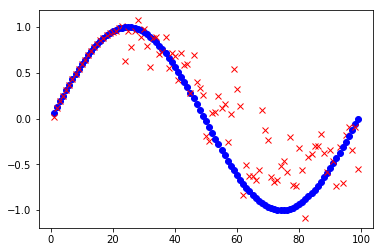

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# the central idea is to only train the weights from reservoir to readout, not within the reservoir itself

# important rules:
# the mean of all weights in the internal w matrix should be 0
# the mean of the input vector should be 0 (centered data)
# a reservoir is believed to have the echo state property if its largest eigenvalue (abs) is < 1.0

def init_w_internal(n): # n cells in the reservoir
    w_0 = np.random.rand(n,n)
    w_0 = w_0 - np.mean(w_0) # weights should have a mean of 0
    w_1 = w_0/spect_r(w_0) # w_1 should now have the echo state property: an input will decay over time.
    return w_1

def init_w_out(n, l): 
    # n cells in the reservoir
    # l cells in the output vector
    w_out = np.random.rand(n,l)
    w_out = w_out - np.mean(w_out)
    return w_out

def spect_r(mat):
    w_ew, w_ev = np.linalg.eig(mat)
    spect_r = abs(w_ew[0])
    return spect_r

def update_reservoir(inp, res, y, w_input, w_internal, w_back):
    a = np.matmul(res, w_internal)
    b = np.matmul(w_back, y)
    c = np.matmul(inp, w_input)
    d = a + b + c
    res = sig(d)
    return res

def sig(a):
    z = 1/(1+np.exp(-a))
    return z

def demonstrate_echo_property(w): # check the echo property of the internal matrix
    n = len(w)
    it_1 = 20
    it_2 = 20
    it_tot = it_1 + it_2
    res_memory = np.zeros((n, it_tot)) # save so you can plot later
    res = np.random.rand(1, n)
    res = res - np.mean(res) # input vectors are to be centered
    print("initial condition")
    print(res)
    res_memory[:,0] = res
    for i in range(1, it_1): # converge to a state
        res = np.matmul(res, w) # update reservoir without output feedback(we only analyse the reservoir)
        res = sig(res)
        res_memory[:,i] = res
    exo = np.random.rand(1, n) # introduce some input
    exo = exo - np.mean(exo) 
    print("introduced state at time 20")
    print(exo)
    res = res + exo
    for i in range(it_1, it_1 + it_2): # see that the state converges to the same pattern as before
        res = np.matmul(res, w)
        res = sig(res)
        res_memory[:,i] = res
    for r in res_memory: # plot development of parameters
        x = np.linspace(0, it_tot,it_tot)
        plt.plot(x, r, 'b-')
    plt.show()
    print("it should be clear that the influence of an introduced state decays with time")
    
def get_output(inp, res, y, w_out):
    a = append_to_array(inp, res.flatten(), y)
    y = np.matmul(a, w_out)    
    if np.isscalar(y):
        y = np.array([y])
    return y

def append_to_array(a, b, c):
    lis = []
    for ax in a:
        lis.append(ax)
    for bx in b:
        lis.append(bx)
    for cx in c:
        lis.append(cx)
    return np.array(lis)

def update_w_out(inp, res, y, d, M, T):

    M, T = correct_shape(M, T)
    M_tnew = append_to_array(inp, res.flatten(), y)    
    M_tnew = M_tnew.reshape(-1, 1).T
    M = np.append(M, M_tnew, axis=0)
    #T_tnew = np.arctanh(d)
    T_tnew = d
    T_tnew = T_tnew.reshape(-1, 1).T
    T = np.append(T, T_tnew, axis=1)
    
    w_out = np.dot( np.linalg.pinv(M) , T.T )
    
    return w_out, M, T

def correct_shape(M, T):
    T = T.reshape(-1, 1).T
    i = len(T[0])
    M = M.reshape(-1, i).T
    return M, T
    
def iteration(inp, res, d, y, w_input, w_internal, w_out, w_back, M, T):
    
    w_out, M, T = update_w_out(inp, res, y, d, M, T)
    res = update_reservoir(inp, res, y, w_input, w_internal, w_back)
    y = get_output(inp, res, y, w_out)
    return y, res, w_out, M, T

k = 1
n = 20 # amount of cells in the reservoir
l = 1
y = np.ones(l)
inp = np.ones(k)
w_input = np.ones((l, n))
w_internal = init_w_internal(n)
#demonstrate_echo_property(w_internal)
w_out = init_w_out(n+k+l, l)
w_back = init_w_out(n, l)

n_timesteps = 100
d_array = np.sin(np.linspace(0,2*np.pi,n_timesteps))
res = np.random.rand(1, n)
res = res - np.mean(res) # input vectors are to be centered
M = append_to_array(inp, res.flatten(), y)
T = d_array[0]
for i in range(1, n_timesteps):
    d = d_array[i]
    y, res, w_out, M, T = iteration(inp, res, d, y, w_input, w_internal, w_out, w_back, M, T)
    plt.plot(i, d, 'bo')
    plt.plot(i, y, 'rx')
plt.show()